In [10]:
import matplotlib
import numpy as np
import seaborn as sns
import time
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from numpy.random import default_rng

from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord

In [11]:
from Corrfunc.theory import DD
from Corrfunc.theory import xi
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_rp_pi_counts_to_wp

In [12]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

# Functions

In [3]:
def compute_xi(r_edges, x, y, z, x_rand, y_rand, z_rand,
               return_full_results=False):
    
    nthreads = 4
    
    start = time.time()
    autocorr=1
    res_dd = DD(autocorr, nthreads, r_edges, x, y, z, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    
    start = time.time()
    autocorr=0
    res_dr = DD(autocorr, nthreads, r_edges, x, y, z,
                X2=x_rand, Y2=y_rand, Z2=z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')

    start = time.time()
    autocorr=1
    res_rr = DD(autocorr, nthreads, r_edges, x_rand, y_rand, z_rand, periodic=False)
    end = time.time()
    print(f'Time: {end-start:.4f} s')
    print()
    
    N = len(x)
    N_rand = len(x_rand)
    xi = convert_3d_counts_to_cf(N, N, N_rand, N_rand,
                                     res_dd, res_dr,
                                     res_dr, res_rr)
    
    if return_full_results:
        return xi, res_dd, res_dr, res_rr
    
    return xi

In [4]:
def radec_to_cartesian(r, ra, dec):
    
    theta = ra * np.pi/180
    phi = (90 - dec) * np.pi/180

    x, y, z = spherical_to_cartesian(r, theta, phi)
    return np.array([x, y, z])

In [5]:
def spherical_to_cartesian(r, theta, phi):
    x       =  r*np.cos(theta)*np.sin(phi)
    y       =  r*np.sin(theta)*np.sin(phi)
    z       =  r*np.cos(phi)
    return np.array([x, y, z])

In [6]:
def generate_shuffled_random(factor, data, rng, redshift_name='redshift_qsoc'):
    N = len(data)
    N_rand = factor*N

    i_vals = np.arange(N)

    i_radec_rand = rng.choice(i_vals, size=N_rand, replace=True)
    ra_rand = data['ra'][i_radec_rand]
    dec_rand = data['dec'][i_radec_rand]

    i_redshift_rand = rng.choice(i_vals, size=N_rand, replace=True)
    redshift_rand = data[redshift_name][i_redshift_rand]
    dist_rand = data['distance'][i_redshift_rand]
    
    x_rand, y_rand, z_rand = radec_to_cartesian(dist_rand, ra_rand, dec_rand)
    
    rand = Table([ra_rand, dec_rand, redshift_rand, dist_rand,
                      x_rand, y_rand, z_rand], 
              names=('ra', 'dec', 'redshift', 'distance', 'x', 'y', 'z'), 
              meta={'name': 'random_shuffle'})
    return rand

# Load in data

In [14]:
fn_photoz = '../data/gaia_photoz.fits'
data_photoz = Table.read(fn_photoz, format='fits')
print(len(data_photoz))

981927


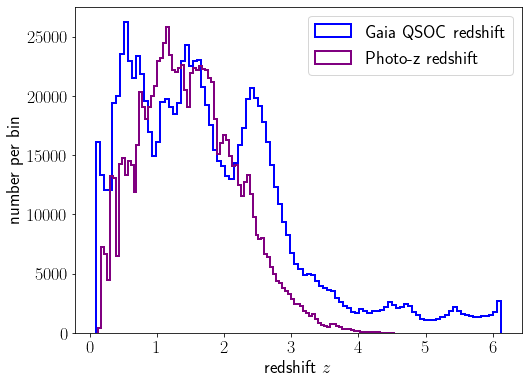

In [18]:
plt.figure(figsize=(8,6))
plt.hist(data_photoz['redshift_qsoc'], bins=100, histtype='step', color='blue', lw=2, label='Gaia QSOC redshift')
plt.hist(data_photoz['redshift_photoz_est'], bins=100, histtype='step', color='purple', lw=2,label='Photo-z redshift')
plt.xlabel(r'redshift $z$')
plt.ylabel('number per bin')
plt.legend()